In [39]:
import warnings
warnings.filterwarnings('ignore')

In [40]:
import jetset
print('tested on jetset',jetset.__version__)

tested on jetset 1.2.0rc13


Depending parameters
====================

In the following we show how to link parameters in the same model or among different models, and how to make a paramter depending on other parameters according to a mathematical expression. 

## Example: linked paramters for EBL

In [1]:
from jetset.jet_model import Jet
from jetset.template_2Dmodel import EBLAbsorptionTemplate
from jetset.model_manager import FitModel

my_jet = Jet(electron_distribution='lppl', name='jet_flaring')
my_jet.parameters.z_cosm.val = 0.01

ebl_franceschini = EBLAbsorptionTemplate.from_name('Franceschini_2008')

composite_model = FitModel(nu_size=500, name='EBL corrected')
composite_model.add_component(my_jet)
composite_model.add_component(ebl_franceschini)

composite_model.show_pars()

composite_model.link_par(par_name='z_cosm', from_model='Franceschini_2008', to_model='jet_flaring')
v=0.03001
my_jet.parameters.z_cosm.val = v
assert (composite_model.Franceschini_2008.parameters.z_cosm.val==v)
assert (composite_model.Franceschini_2008.parameters.z_cosm.linked==True)

composite_model.composite_expr = '%s*%s'%(my_jet.name,ebl_franceschini.name)
composite_model.eval()

#if plot is True:
#    composite_model.plot_model()

composite_model.save_model('ebl_jet.pkl')
new_composite_model=FitModel.load_model('ebl_jet.pkl')
new_composite_model.show_pars()
v=2.0
new_composite_model.jet_flaring.parameters.z_cosm.val=v
print('new_composite_model.Franceschini_2008.parameters.z_cosm.val',new_composite_model.Franceschini_2008.parameters.z_cosm.val,'v',v)
assert (new_composite_model.Franceschini_2008.parameters.z_cosm.val == v)
assert (new_composite_model.Franceschini_2008.parameters.z_cosm.linked == True)

/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/model_manager.py:147: UserWarning: no cosmology defined, using default FlatLambdaCDM(name="Planck13", H0=67.8 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0483)
  warnings.warn('no cosmology defined, using default %s'%self.cosmo)


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_flaring,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_flaring,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_flaring,B,magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,False
jet_flaring,beam_obj,beaming,lorentz-factor*,1.000000e+01,1.000000e-04,--,False,False
jet_flaring,z_cosm,redshift,,1.000000e-02,0.000000e+00,--,False,False
jet_flaring,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_flaring,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_flaring,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_flaring,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False
jet_flaring,s,LE_spectral_slope,,2.000000e+00,-1.000000e+01,1.000000e+01,False,False


==> par: z_cosm from model: Franceschini_2008 linked to same parameter in model jet_flaring
==> par: z_cosm from model: Franceschini_2008 linked to same parameter in model jet_flaring


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_flaring,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_flaring,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_flaring,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_flaring,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False
jet_flaring,s,LE_spectral_slope,,2.000000e+00,-1.000000e+01,1.000000e+01,False,False
jet_flaring,r,spectral_curvature,,4.000000e-01,-1.500000e+01,1.500000e+01,False,False
jet_flaring,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_flaring,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_flaring,B,magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,False
jet_flaring,beam_obj,beaming,lorentz-factor*,1.000000e+01,1.000000e-04,--,False,False


new_composite_model.Franceschini_2008.parameters.z_cosm.val 2.0 v 2.0


## Example: depending pars for bkn power-law emitters

here we create a custom `bkn` distribution where we impose a functional dependence among the low and high-energy spectral index.

In [2]:
from jetset.jet_emitters import EmittersDistribution
import numpy as np



from jetset.jet_model import Jet

j = Jet(emitters_distribution='bkn')


j.parameters


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,1.000000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.500000e+00,-1.000000e+01,1.000000e+01,False,False


None

the functional dependence can be provided by a python function, where the argument (`p` in this case) is the same name as the parameter:

In [3]:
def f_p(p):
    return p+1
j.make_dependent_par(par='p_1',depends_on=['p'],par_expr=f_p)
j.parameters.p.val=2
np.testing.assert_allclose(j.parameters.p_1.val, j.parameters.p.val + 1)
j.parameters

==> par p_1 is now depending on ['p'] according to expr:p_1 =
def f_p(p):
    return p+1



model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,1.000000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p(M),LE_spectral_slope,,2.000000e+00,-1.000000e+01,1.000000e+01,False,False


None

as you can notice, now a message is shown describing the dependence of the parameters 

It is also possible to set the dependence function as a string that can be evaluated

In [4]:
j.make_dependent_par(par='p_1',depends_on=['p'],par_expr='p+1')
j.parameters.p.val=2
np.testing.assert_allclose(j.parameters.p_1.val, j.parameters.p.val + 1)
j.parameters

==> par p_1 is now depending on ['p'] according to expr:p_1 =
p+1


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,1.000000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p(M),LE_spectral_slope,,2.000000e+00,-1.000000e+01,1.000000e+01,False,False


None

In principle, you can use strings for short expressions, and functions for more complicated formulas.

You can print the actual expression/function for the depending parameter using the `print_par_expr` method:

In [5]:
j.parameters.p_1.print_par_expr

==> par p_1 is depending on ['p'] according to expr:   p_1 =
p+1


In [6]:
j.save_model('jet.pkl')
new_jet=Jet.load_model('jet.pkl')


==> par p_1 is now depending on ['p'] according to expr:p_1 =
p+1


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p(M),LE_spectral_slope,,2.000000e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,"*p_1(D,p)",HE_spectral_slope,,3.000000e+00,-1.000000e+01,1.000000e+01,False,True
jet_leptonic,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,1.000000e+01,1.000000e-04,--,False,False


In [7]:
new_jet.parameters.p.val=2.5
np.testing.assert_allclose(new_jet.parameters.p_1.val, new_jet.parameters.p.val + 1)
new_jet.parameters

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p(M),LE_spectral_slope,,2.500000e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,"*p_1(D,p)",HE_spectral_slope,,3.500000e+00,-1.000000e+01,1.000000e+01,False,True
jet_leptonic,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,1.000000e+01,1.000000e-04,--,False,False


None

## Example depending par: Building a Jet model with B function of R_H and R_0

In this example we create a fuctional dependence among the paramters `B`, `R_H` introducing user custom pararameters. Wewant that  the value of the mangentic field in the jet is a function or `R_H`, and  of the initial value of `B=B0` at `R=R_H0`, according to the expression: 

$B=B_0(R_0/R_H)^{1.1}$

In [8]:
jet=Jet(emitters_distribution='plc')
fit_model_lsb=FitModel( jet=jet, name='SSC-best-fit-lsb',template=None)
fit_model_lsb.jet_leptonic.parameters.beam_obj.fit_range = [5, 50]
fit_model_lsb.jet_leptonic.parameters.R_H.val=5E17
fit_model_lsb.jet_leptonic.parameters.R_H.frozen=False
fit_model_lsb.jet_leptonic.parameters.R_H.fit_range = [1E15, 1E19]
fit_model_lsb.jet_leptonic.parameters.R.fit_range = [10 ** 15.5, 10 ** 17.5]

fit_model_lsb.jet_leptonic.add_user_par(name='B0',units='G',val=1E3,val_min=0,val_max=None)
fit_model_lsb.jet_leptonic.add_user_par(name='R0', units='cm', val=5E13, val_min=0, val_max=None)
fit_model_lsb.jet_leptonic.add_user_par(name='m_B', val=1, val_min=1, val_max=2)
fit_model_lsb.jet_leptonic.parameters.R0.frozen=True
fit_model_lsb.jet_leptonic.parameters.B0.frozen=True

def par_func(R0,B0,R_H,m_B): 
    return B0*np.power((R0/R_H),m_B)

fit_model_lsb.jet_leptonic.make_dependent_par(par='B', depends_on=['B0', 'R0', 'R_H','m_B'], par_expr=par_func)

B0=fit_model_lsb.jet_leptonic.parameters.B0.val
R0 = fit_model_lsb.jet_leptonic.parameters.R0.val
R_H = fit_model_lsb.jet_leptonic.parameters.R_H.val
m_B= fit_model_lsb.jet_leptonic.parameters.m_B.val

np.testing.assert_allclose(fit_model_lsb.jet_leptonic.parameters.B.val, par_func(R0,B0,R_H,m_B))

==> par B is now depending on ['B0', 'R0', 'R_H', 'm_B'] according to expr:B =
def par_func(R0,B0,R_H,m_B): 
    return B0*np.power((R0/R_H),m_B)



/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/model_manager.py:147: UserWarning: no cosmology defined, using default FlatLambdaCDM(name="Planck13", H0=67.8 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0483)
  warnings.warn('no cosmology defined, using default %s'%self.cosmo)


In [9]:

fit_model_lsb.jet_leptonic.parameters

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H(M),region_position,cm,5.000000e+17,0.000000e+00,--,False,False
jet_leptonic,"*B(D,m_B)",magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,lorentz-factor*,1.000000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_cut,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.000000e+00,-1.000000e+01,1.000000e+01,False,False


None

In [10]:
fit_model_lsb.jet_leptonic.parameters

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H(M),region_position,cm,5.000000e+17,0.000000e+00,--,False,False
jet_leptonic,"*B(D,m_B)",magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,lorentz-factor*,1.000000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_cut,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.000000e+00,-1.000000e+01,1.000000e+01,False,False


None

In [11]:
fit_model_lsb.save_model('test.pkl')

In [12]:
fit_model_lsb=FitModel.load_model('test.pkl')

==> par B is now depending on ['B0', 'R0', 'R_H', 'm_B'] according to expr:B =
def par_func(R0,B0,R_H,m_B): 
    return B0*np.power((R0/R_H),m_B)



In [13]:
B0=fit_model_lsb.jet_leptonic.parameters.B0.val
R0 = fit_model_lsb.jet_leptonic.parameters.R0.val
R_H = fit_model_lsb.jet_leptonic.parameters.R_H.val
m_B= fit_model_lsb.jet_leptonic.parameters.m_B.val

np.testing.assert_allclose(fit_model_lsb.jet_leptonic.parameters.B.val, par_func(R0,B0,R_H,m_B))

## Example depending par: fitting with a Jet model with depending pars


In this example we show how to use the previous model during a Fit

In [14]:
from jetset.test_data_helper import  test_SEDs
from jetset.data_loader import ObsData,Data
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs

In [15]:
data=Data.from_file(test_SEDs[1])


***  binning data  ***
---> N bins= 89
---> bin_widht= 0.2



/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/astropy/table/table.py:1187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  newcol = col[slice_]


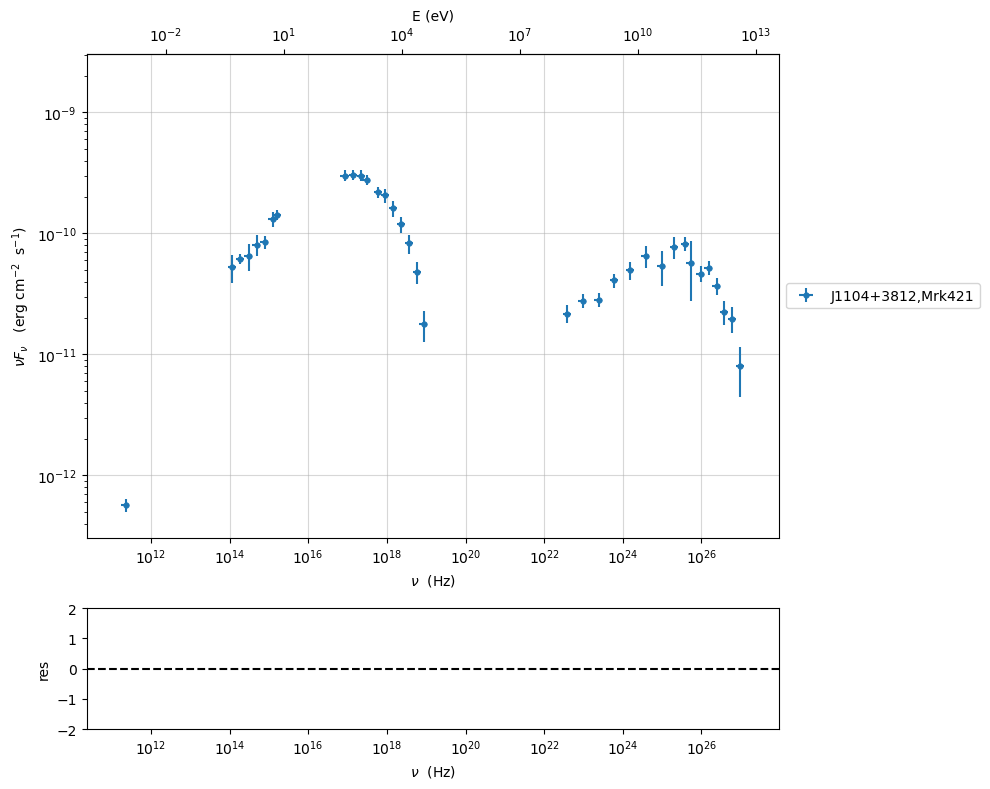

In [16]:
sed_data=ObsData(data_table=data)
sed_data.group_data(bin_width=0.2)

sed_data.add_systematics(0.1,[10.**6,10.**29])
p=sed_data.plot_sed()


*** evaluating spectral indices for data ***



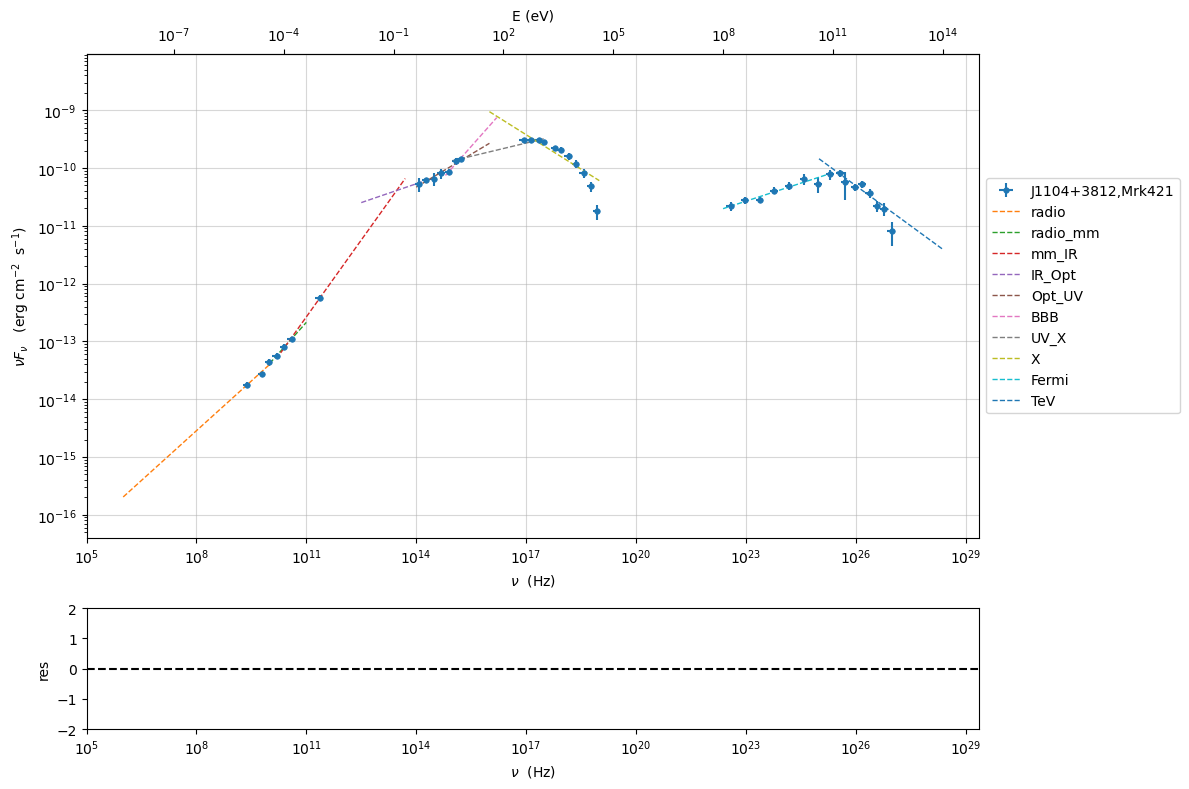

In [19]:
from jetset.sed_shaper import  SEDShape
my_shape=SEDShape(sed_data)
my_shape.eval_indices(minimizer='lsb',silent=True)
p=my_shape.plot_indices()


In [20]:
mm,best_fit=my_shape.sync_fit(check_host_gal_template=False,
                  Ep_start=None,
                  minimizer='lsb',
                  silent=True,
                  fit_range=[10.,21.])


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [10.0, 21.0]
---> class:  HSP





model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.545300e-01,-1.545300e-01,9.534795e-03,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-1.023245e-02,-1.023245e-02,1.433073e-03,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,1.672267e+01,1.672267e+01,4.139942e-02,--,1.667039e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-9.491659e+00,-9.491659e+00,2.515285e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> sync       nu_p=+1.672267e+01 (err=+4.139942e-02)  nuFnu_p=-9.491659e+00 (err=+2.515285e-02) curv.=-1.545300e-01 (err=+9.534795e-03)




*** Log-Polynomial fitting of the IC component ***
---> fit range: [23.0, 29.0]
---> LogCubic fit




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-2.098186e-01,-2.098186e-01,3.133032e-02,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-4.661868e-02,-4.661868e-02,2.178352e-02,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,2.524926e+01,2.524926e+01,1.147759e-01,--,2.529412e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.011085e+01,-1.011085e+01,3.498963e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> IC         nu_p=+2.524926e+01 (err=+1.147759e-01)  nuFnu_p=-1.011085e+01 (err=+3.498963e-02) curv.=-2.098186e-01 (err=+3.133032e-02)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
The rescale method as been replaced by the setlim method
please notice that now jetset uses log axis rather than loglog plots
so, the correct way to use it is rescale(x_min=8)->setlim(x_min=1E8)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


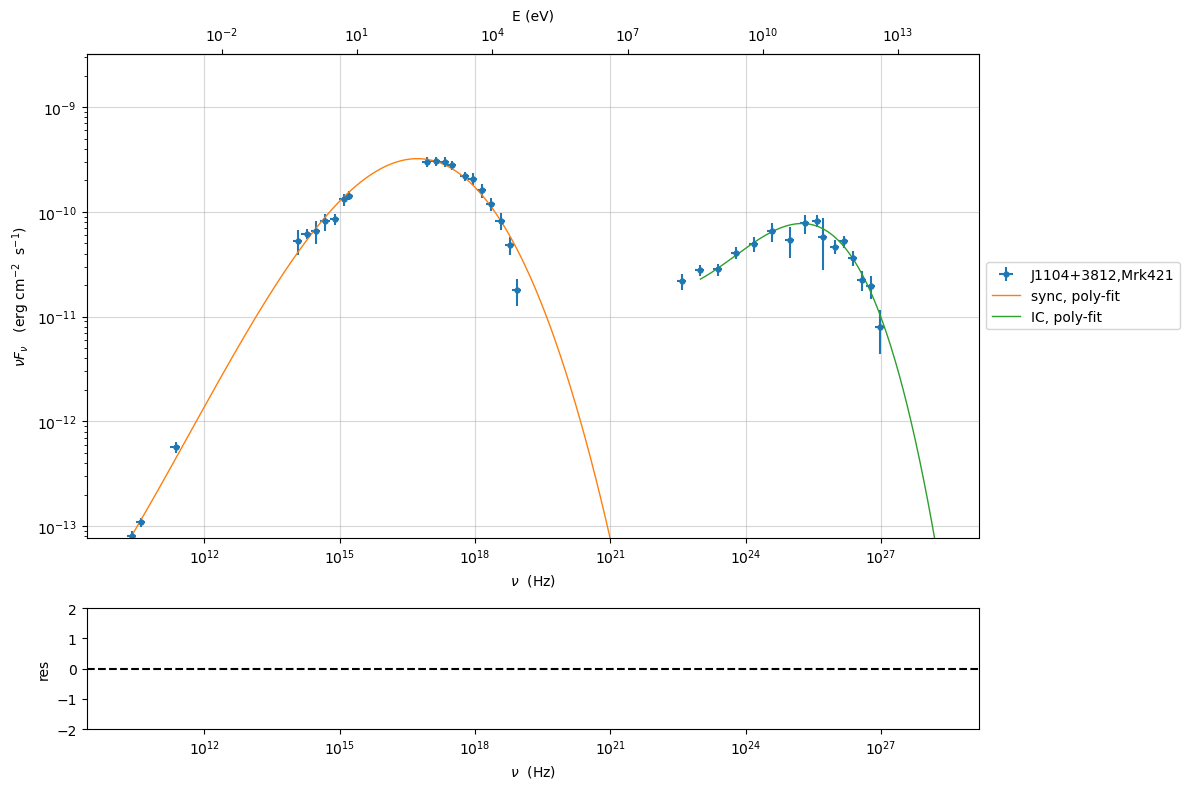

In [21]:
my_shape.IC_fit(fit_range=[23.,29.],minimizer='minuit',silent=True)
p=my_shape.plot_shape_fit()
p.setlim(y_min=1E-15)

In [22]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='lppl',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E12,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet.pkl')


***  constrains parameters from observable ***



/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/obs_constrain.py:650: RankWarning: Polyfit may be poorly conditioned
  return func(*args, **kwargs),completed


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,3.112712e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.080000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.060842e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.188500e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.181578e+00,-1.000000e+01,1.000000e+01,False,False


In [23]:
from jetset.minimizer import fit_SED,ModelMinimizer

from jetset.model_manager import  FitModel
from jetset.jet_model import Jet
prefit_jet=Jet.load_model('prefit_jet.pkl')

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.060842e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.188500e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.181578e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.726502e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.112712e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


In [24]:
fit_model=FitModel( jet=prefit_jet, name='SSC-best-fit-lsb',template=None)
fit_model.parameters

/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/model_manager.py:147: UserWarning: no cosmology defined, using default FlatLambdaCDM(name="Planck13", H0=67.8 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0483)
  warnings.warn('no cosmology defined, using default %s'%self.cosmo)


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.060842e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.188500e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.181578e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.726502e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.112712e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


None

In [25]:
fit_model.jet_leptonic.parameters.beam_obj.fit_range = [5, 50]
fit_model.jet_leptonic.parameters.R_H.val=5E17
fit_model.jet_leptonic.parameters.R_H.frozen=False
fit_model.jet_leptonic.parameters.R_H.fit_range = [1E15, 1E19]
fit_model.jet_leptonic.parameters.R.fit_range = [10 ** 15.5, 10 ** 17.5]
fit_model.jet_leptonic.parameters.gamma0_log_parab.fit_range = [1E3,1E6]
fit_model.jet_leptonic.parameters.gmin.fit_range = [10,1000]
fit_model.jet_leptonic.parameters.gmax.fit_range = [1E5,1E8]

fit_model.jet_leptonic.add_user_par(name='B0',units='G',val=1E3,val_min=0,val_max=None)
fit_model.jet_leptonic.add_user_par(name='R0', units='cm', val=5E13, val_min=0, val_max=None)
fit_model.jet_leptonic.add_user_par(name='m_B', val=1, val_min=1, val_max=2)
fit_model.jet_leptonic.parameters.R0.frozen=True
fit_model.jet_leptonic.parameters.B0.frozen=True

def par_func(R0,B0,R_H,m_B): 
    return B0*np.power((R0/R_H),m_B)

fit_model.jet_leptonic.make_dependent_par(par='B', depends_on=['B0', 'R0', 'R_H','m_B'], par_expr=par_func)
fit_model.parameters

==> par B is now depending on ['B0', 'R0', 'R_H', 'm_B'] according to expr:B =
def par_func(R0,B0,R_H,m_B): 
    return B0*np.power((R0/R_H),m_B)



model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.060842e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.188500e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.181578e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.726502e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.112712e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H(M),region_position,cm,5.000000e+17,0.000000e+00,--,False,False
jet_leptonic,"*B(D,m_B)",magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


None

Text(0, 0.5, 'B (G)')

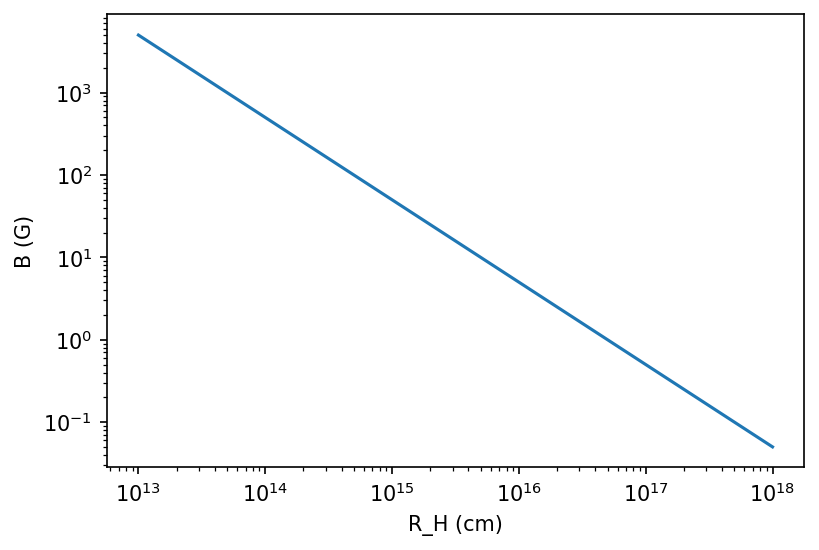

In [26]:
%matplotlib inline
plt.figure(dpi=150)
R_H_array=np.logspace(13,18,100)
B_array=np.zeros(R_H_array.shape)
for ID,R_H in enumerate(R_H_array):
    fit_model_lsb.jet_leptonic.parameters.R_H.val=R_H
    B_array[ID]=fit_model_lsb.jet_leptonic.parameters.B.val

plt.loglog(R_H_array,B_array)
plt.xlabel('R_H (cm)')
plt.ylabel('B (G)')

In [27]:
fit_model.jet_leptonic.parameters.R_H.val=5E17

In [28]:
fit_model.parameters

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.060842e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.188500e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.181578e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.726502e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.112712e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H(M),region_position,cm,5.000000e+17,0.000000e+00,--,False,False
jet_leptonic,"*B(D,m_B)",magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


None

As a resuslt of the best fit modeling, we are able to determine the value of `R_H`. We now perform the fit with minuit to get a better estimate of the errors

In [29]:
model_minimizer_minuit=ModelMinimizer('minuit')


In [30]:
best_fit_minuit=model_minimizer_minuit.fit(fit_model,
                                     sed_data,
                                     1E11,
                                     1E29,
                                     fitname='SSC-best-fit-minuit',
                                     repeat=3)

filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 35

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

- best chisq=1.55264e+01

fit run: 1
- old chisq=1.55264e+01


0it [00:00, ?it/s]

- best chisq=1.55263e+01

fit run: 2
- old chisq=1.55263e+01


0it [00:00, ?it/s]

- best chisq=1.55263e+01

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-minuit


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,5.707170e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,6.628146e+05,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.096259e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.542531e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.275366e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.219607e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.022039e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H(M),region_position,cm,6.570078e+17,0.000000e+00,--,False,False
jet_leptonic,"*B(D,m_B)",magnetic_field,gauss,4.997430e-02,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,lorentz-factor*,4.643401e+01,1.000000e-04,--,False,False



converged=True
calls=187
mesg=


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.53                      │              Nfcn = 187              │
│ EDM = 0.000156 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0  │    571    │    18     │            │            │   10    │  1000   │       │
│ 1 │ par_1  │  0.663e6  │  0.011e6  │            │            │ 100000  │  1e+08  │       │
│ 2 │ par_2  │   0.910   │   0.029   │            │            │    0    │         │       │
│ 3 │ par_3  │  35.4e3   │   3.3e3   │            │            │  1000   │  1e+06  │       │
│ 4 │ par_4  │   2.275   │   0.015   │            │            │   -10   │   10    │       │
│ 5 │ par_5  │   0.72    │   0.04    │            │            │   -15   │   15    │       │
│ 6 │ par_6  │  30.2e15  │  0.6e15   │            │            │3.16228e+15│3.16228e+17│       │
│ 7 │ par_7  │  0.66e18  │  0.06e18  │            │            │  1e+15  │  1e+19  │       │
│ 8 │ par_8  │   46.4    │    0.5    │            │            │    5    │   50    │       │
│ 9 │ par_9  │  0.0956   │  0.0020   │            │            │    0    │         │       │
│ 10│ par_10 │   1.044   │   0.008   │            │            │    1    │    2    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│        │     par_0     par_1     par_2     par_3     par_4     par_5     par_6     par_7     par_8     par_9    par_10 │
├────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  par_0 │       314 -4.13e+04     -0.19  3.01e+04     0.157    0.0518  3.01e+15  6.09e+17      -2.3   0.00721   -0.0841 │
│  par_1 │ -4.13e+04  1.27e+08      52.7 -7.33e+06     -28.7     -1.24 -1.17e+18  -8.6e+19       227     -1.32      9.53 │
│  par_2 │     -0.19      52.7  0.000853     -11.3 -1.06e-05 -1.51e-05 -4.56e+12  -3.1e+14 -0.000306   3.7e-06  4.78e-05 │
│  par_3 │  3.01e+04 -7.33e+06     -11.3  1.11e+07      42.8      64.2  1.11e+18  1.49e+20      -455      1.44     -21.2 │
│  par_4 │     0.157     -28.7 -1.06e-05      42.8  0.000238   0.00014  5.68e+12  7.08e+14  -0.00171  5.84e-06 -0.000101 │
│  par_5 │    0.0518     -1.24 -1.51e-05      64.2   0.00014   0.00132  2.46e+12   3.9e+14   0.00025  4.33e-06  -8.1e-05 │
│  par_6 │  3.01e+15 -1.17e+18 -4.56e+12  1.11e+18  5.68e+12  2.46e+12  3.23e+29  2.08e+31  -9.7e+13  3.66e+11 -2.89e+12 │
│  par_7 │  6.09e+17  -8.6e+19  -3.1e+14  1.49e+20  7.08e+14   3.9e+14  2.08e+31  3.11e+33 -7.51e+15  2.32e+13 -4.42e+14 │
│  par_8 │      -2.3       227 -0.000306      -455  -0.00171   0.00025  -9.7e+13 -7.51e+15     0.279  0.000108    0.0014 │
│  par_9 │   0.00721     -1.32   3.7e-06      1.44  5.84e-06  4.33e-06  3.66e+11  2.32e+13  0.000108  3.98e-06 -4.61e-06 │
│ par_10 │   -0.0841      9.53  4.78e-05     -21.2 -0.000101  -8.1e-05 -2.89e+12 -4.42e+14    0.0014 -4.61e-06  6.86e-05 │
└────────┴─────────────────────────────────────────────────────────────────────────────────────────────────────────────

dof=24
chisq=15.526262, chisq/red=0.646928 null hypothesis sig=0.904412

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,5.707170e+02,5.707170e+02,1.770879e+01,--,4.697542e+02,1.000000e+01,1.000000e+03,False
jet_leptonic,gmax,6.628146e+05,6.628146e+05,1.128277e+04,--,1.373160e+06,1.000000e+05,1.000000e+08,False
jet_leptonic,N,9.096259e-01,9.096259e-01,2.920374e-02,--,9.060842e-01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,3.542531e+04,3.542531e+04,3.330848e+03,--,3.188500e+04,1.000000e+03,1.000000e+06,False
jet_leptonic,s,2.275366e+00,2.275366e+00,1.541557e-02,--,2.181578e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,7.219607e-01,7.219607e-01,3.630592e-02,--,7.726502e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,3.022039e+16,3.022039e+16,5.684398e+14,--,3.112712e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H(M),6.570078e+17,6.570078e+17,5.574426e+16,--,5.000000e+17,1.000000e+15,1.000000e+19,False
jet_leptonic,"*B(D,m_B)",4.997430e-02,--,--,--,1.000000e-01,0.000000e+00,--,True
jet_leptonic,beam_obj,4.643401e+01,4.643401e+01,5.282534e-01,--,2.500000e+01,5.000000e+00,5.000000e+01,False


-------------------------------------------------------------------------




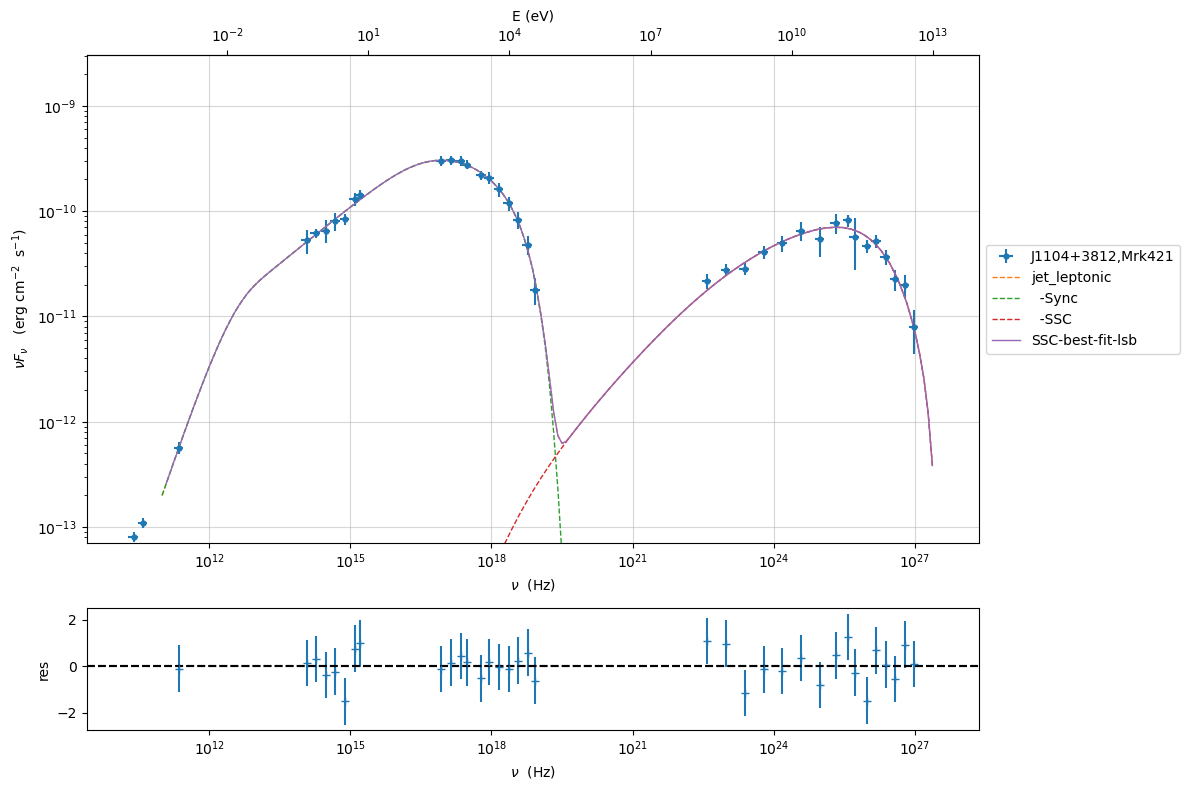

In [31]:
fit_model.plot_model(sed_data=sed_data)

Text(0, 0.5, 'B (G)')

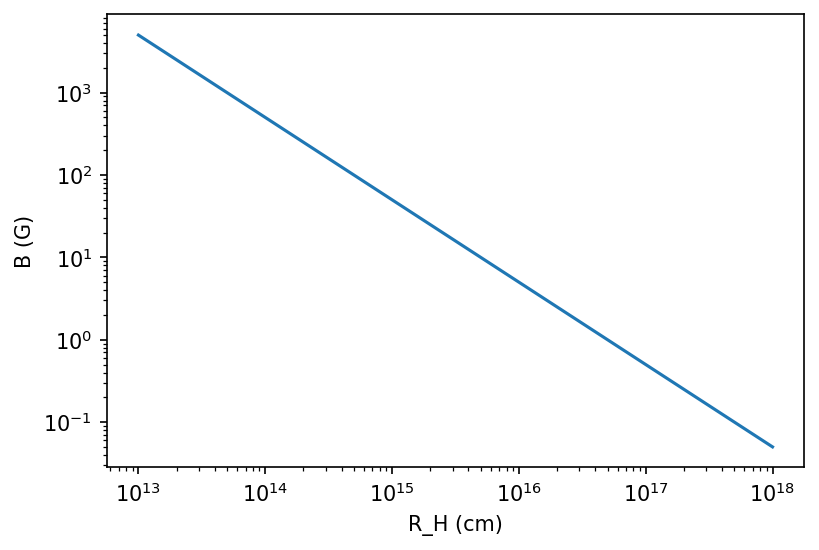

In [32]:
%matplotlib inline
plt.figure(dpi=150)
R_H_array=np.logspace(13,18,100)
B_array=np.zeros(R_H_array.shape)
for ID,R_H in enumerate(R_H_array):
    fit_model_lsb.jet_leptonic.parameters.R_H.val=R_H
    B_array[ID]=fit_model_lsb.jet_leptonic.parameters.B.val

plt.loglog(R_H_array,B_array)
plt.xlabel('R_H (cm)')
plt.ylabel('B (G)')

In [33]:
fit_model.save_model('test.pkl')


In [34]:
from jetset.model_manager import  FitModel

new_fit_model=FitModel.load_model('test.pkl')

==> par B is now depending on ['B0', 'R0', 'R_H', 'm_B'] according to expr:B =
def par_func(R0,B0,R_H,m_B): 
    return B0*np.power((R0/R_H),m_B)



In [35]:
new_fit_model.parameters

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,5.707170e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,6.628146e+05,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.096259e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.542531e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.275366e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.219607e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.022039e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H(M),region_position,cm,6.570078e+17,0.000000e+00,--,False,False
jet_leptonic,"*B(D,m_B)",magnetic_field,gauss,4.997430e-02,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,lorentz-factor*,4.643401e+01,1.000000e-04,--,False,False


None

In [36]:
new_fit_model.jet_leptonic.parameters.reset_dependencies()

In [37]:
new_fit_model.parameters

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,5.707170e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,6.628146e+05,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.096259e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.542531e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.275366e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.219607e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.022039e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,6.570078e+17,0.000000e+00,--,False,False
jet_leptonic,B,magnetic_field,gauss,4.997430e-02,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,lorentz-factor*,4.643401e+01,1.000000e-04,--,False,False


None